In [81]:
from copy import deepcopy
from pathlib import Path
from pprint import pprint 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 110)

In [82]:
import datetime as dt
from joblib import Memory
import pickle
from shutil import rmtree

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV, 
    StratifiedKFold,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.pipeline import Pipeline

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis

from lib.pipeline_helpers import fit_and_score_features, p_to_var
from lib.plotting import plot_kaplan_meier

set_config(display="text")  # displays text representation of estimators

In [83]:
import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

warnings.simplefilter("ignore", UserWarning) # e.g. suppress wanrings such as UserWarning: all coefficients are zero, consider decreasing alpha.
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [84]:
# local paths
data_dir_proc = Path('data/preprocess')
data_dir_eda = Path('data/eda')
data_dir_wgcna = Path('data/wgcna')
results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)

# load data

In [85]:
survival = pd.read_parquet(data_dir_proc / 'survival.parquet')
print(survival.head())
print(survival.shape)

                     _PATIENT  OS  OS.time  DSS  DSS.time  DFI  DFI.time  PFI  PFI.time  Redaction
TCGA-69-7978-01  TCGA-69-7978   0    134.0  0.0     134.0  NaN       NaN    0     134.0        NaN
TCGA-62-8399-01  TCGA-62-8399   0   2696.0  0.0    2696.0  0.0    2696.0    0    2696.0        NaN
TCGA-78-7539-01  TCGA-78-7539   0    791.0  0.0     791.0  1.0     688.0    1     688.0        NaN
TCGA-73-4658-01  TCGA-73-4658   1   1600.0  0.0    1600.0  0.0    1600.0    0    1600.0        NaN
TCGA-44-6775-01  TCGA-44-6775   0    705.0  0.0     705.0  1.0     684.0    1     684.0        NaN
(506, 10)


In [86]:
clinical_cat = pd.read_parquet(data_dir_eda / 'clinical_cat.parquet')
clinical_num = pd.read_parquet(data_dir_eda / 'clinical_num.parquet')
clinical = clinical_cat.merge(clinical_num, how='inner', left_index=True, right_index=True)
print(clinical.head())
print(clinical.shape)

                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ... stopped_smoking_year  \
TCGA-69-7978-01    MALE            8255/3        C34.1       No      UNKNOWN  ...                  NaN   
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...                  NaN   
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...               1981.0   
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...                  NaN   
TCGA-44-6775-01  FEMALE            8140/3        C34.1       No      UNKNOWN  ...               2005.0   

                tobacco_smoking_history year_of_initial_pathologic_diagnosis year_of_tobacco_smoking_onset  \
TCGA-69-7978-01     2_former_smoker<15y                               2011.0                           NaN   
TCGA-62-8399-01          4_never_smoked                               2006.0                           NaN   
TCGA-78-7539-01    3_former_smoke

In [87]:
eigengenes = pd.read_parquet(data_dir_wgcna / 'eigengenes.parquet')
print(eigengenes.head())
print(eigengenes.shape)

                 eigengene_1  eigengene_2  eigengene_3  eigengene_4  eigengene_6  eigengene_9
TCGA-69-7978-01    -1.679827   -28.597754    24.458553    49.222194     0.015382     2.912907
TCGA-62-8399-01     8.116884    -8.755893    22.903491   -13.438406     6.946744    -0.216088
TCGA-78-7539-01    -3.357579    12.129143    -5.964686   -10.713861    -1.599267    -8.709475
TCGA-73-4658-01   -38.307635     0.874504    -7.055459    41.814082     0.881820     1.635860
TCGA-44-6775-01    -4.370142     5.071119    21.828292    42.764854    -0.643390    -5.425188
(506, 6)


In [88]:
event_col = 'OS'
time_col = 'OS.time'
clinical_cat_cols = clinical.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
clinical_num_cols = clinical.select_dtypes(include=np.number).columns.to_list()
eigengene_cols = eigengenes.columns
# eigengene_cols = eigengenes.columns[:500].to_series()

In [89]:
y = Surv.from_dataframe(event=event_col, time=time_col, data=survival)
print(y.shape)
print(pd.DataFrame.from_records(y).head())
print(f'overall censoring rate: {(~y[event_col]).mean():.3}')

(506,)
      OS  OS.time
0  False    134.0
1  False   2696.0
2  False    791.0
3   True   1600.0
4  False    705.0
overall censoring rate: 0.638


In [90]:
X = clinical.loc[:, clinical_cat_cols + clinical_num_cols]\
    .merge(eigengenes.loc[:, eigengene_cols], how='inner', left_index=True, right_index=True)
print(X.shape)
print(X.head())

(506, 27)
                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ... eigengene_2 eigengene_3  \
TCGA-69-7978-01    MALE            8255/3        C34.1       No      UNKNOWN  ...  -28.597754   24.458553   
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...   -8.755893   22.903491   
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...   12.129143   -5.964686   
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...    0.874504   -7.055459   
TCGA-44-6775-01  FEMALE            8140/3        C34.1       No      UNKNOWN  ...    5.071119   21.828292   

                eigengene_4 eigengene_6 eigengene_9  
TCGA-69-7978-01   49.222194    0.015382    2.912907  
TCGA-62-8399-01  -13.438406    6.946744   -0.216088  
TCGA-78-7539-01  -10.713861   -1.599267   -8.709475  
TCGA-73-4658-01   41.814082    0.881820    1.635860  
TCGA-44-6775-01   42.764854   -0.643390   -5.425188  

[5 rows x 

# pipeline

In [91]:
cachedir = "./.cache"
memory = Memory(location=cachedir, verbose=0)

clinical_cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encode', OneHotEncoder(drop='if_binary', sparse_output=False)),
    ('varthresh', VarianceThreshold(threshold=p_to_var(0.05))),
])

clinical_num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('varthresh', VarianceThreshold(threshold=1e-5)),
    ('scale', StandardScaler()),
])

eigengene_pipe = Pipeline([
    ('scale', StandardScaler()),
])

preprocess_pipe = ColumnTransformer([
    ('clinical_cat', clinical_cat_pipe, clinical_cat_cols),
    ('clinical_num', clinical_num_pipe, clinical_num_cols),
    ('eigengenes', eigengene_pipe, eigengene_cols),
])

coxnet_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('select', SelectKBest(fit_and_score_features, k=5)),
    ('coxnet', CoxnetSurvivalAnalysis(max_iter=10000))
], memory=memory)

# params

alpha | l1_ratio | model
----- | -------- | ---
`0`     |          | ordinary regression (OLS?)
`>0`    | 0        | ridge
`>0`    | 1        | lasso

## l1_ratios

In [92]:
# make l1_ratios list and check bounds 
n_l1_ratios = 9
l1_ratios = np.linspace(0.1, 0.9, n_l1_ratios) # 0=Ridge, 1=Lasso
print(len(l1_ratios))
pprint(l1_ratios)

9
array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


## alphas

In [93]:
# make alphas list and check bounds 
n_alphas = 10
min_alpha = 0.001
max_alpha = 1.0
alphas = [float(x) for x in np.logspace(np.log(min_alpha), np.log(max_alpha), n_alphas, base=np.exp(1))]
# alphas = [float(x) for x in np.logspace(-3, 0.2, n_alphas)]
print(len(alphas))
pprint(alphas)
alphas = [[x] for x in alphas] # the alphas parameter expects a list

10
[0.0010000000000000007,
 0.002154434690031885,
 0.004641588833612782,
 0.009999999999999998,
 0.021544346900318843,
 0.0464158883361278,
 0.09999999999999999,
 0.21544346900318836,
 0.46415888336127786,
 1.0]


In [94]:
params = {
    "preprocess__clinical_cat__impute__strategy": ['constant'],
    "select__k": np.arange(0, 21, 1),
    "coxnet__l1_ratio": l1_ratios,
    "coxnet__alphas": alphas,  
}

# classifier

In [95]:
cv = StratifiedKFold(
    n_splits=3, 
    shuffle=True, 
    random_state=42,
    # random_state=123,
)

cls = RandomizedSearchCV(
    estimator=coxnet_pipe,
    param_distributions=params,
    n_iter=5000, # number of random parameter combinations
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    error_score=0.5,
    # error_score='raise',
)

# fit

In [96]:
cls.fit(X, y)

memory.clear(warn=False)
rmtree(cachedir)

In [97]:
filename = f'cls_coxnet_wgcna_{dt.datetime.now().strftime("%Y%m%d_%H%M%S")}.sav'
filepath = Path(results_dir) / filename
print(filepath)
pickle.dump(cls, open(filepath, 'wb'))

results/cls_coxnet_wgcna_20251203_231821.sav


# best model

In [98]:
best_model = cls.best_estimator_

print("Best parameters:")
pprint(cls.best_params_)
print("Best score:", cls.best_score_)

Best parameters:
{'coxnet__alphas': [0.021544346900318843],
 'coxnet__l1_ratio': np.float64(0.1),
 'preprocess__clinical_cat__impute__strategy': 'constant',
 'select__k': np.int64(7)}
Best score: 0.7559202502401221


In [99]:
best_coefs = pd.Series(
    best_model.named_steps["coxnet"].coef_.flatten(), 
    # index=best_model.named_steps['preprocess'].get_feature_names_out(),
    index=best_model.named_steps['preprocess'].get_feature_names_out()[best_model.named_steps['select'].get_support()]
)
best_coefs_non_zero = best_coefs[best_coefs != 0]
best_coefs_non_zero = best_coefs_non_zero[best_coefs_non_zero.abs().sort_values(ascending=False).index]
print(f'n non-zero coefs: {len(best_coefs_non_zero)}')
print()
print(best_coefs_non_zero[:20])

n non-zero coefs: 7

clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -0.974735
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.480482
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.310740
clinical_cat__pathologic_N_N0                                                       -0.266793
eigengenes__eigengene_2                                                             -0.264740
clinical_cat__pathologic_stage_Stage I                                              -0.259061
clinical_cat__pathologic_N_N1/N2/N3                                                  0.190730
dtype: float64


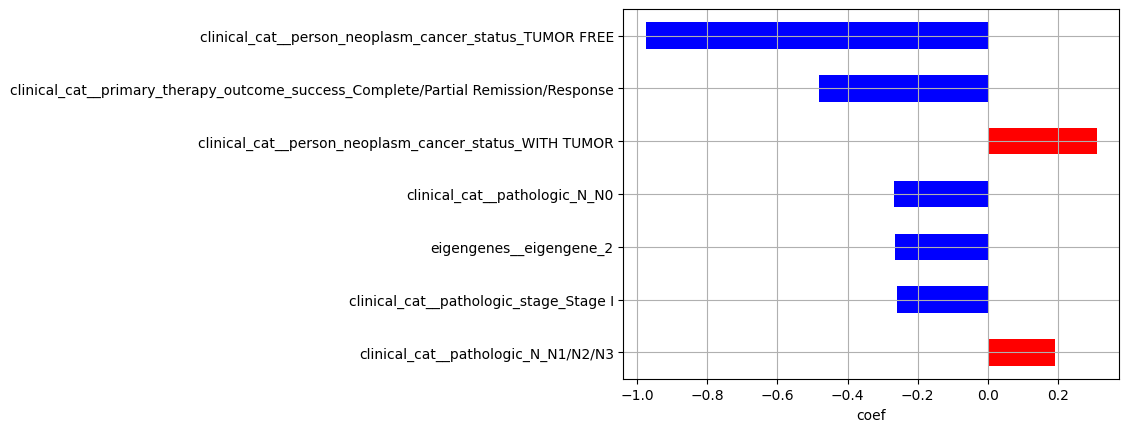

In [100]:
max_n_coefs = 20
if len(best_coefs_non_zero) > 0:
    _ = deepcopy(best_coefs_non_zero)
    if len(_) > max_n_coefs:
        _ = _[:max_n_coefs]
    _ = _[::-1]
    ax = _.plot.barh(
        legend=False, 
        color = (_ > 0).map({True: 'red', False: 'blue'}),
    )
    ax.set_xlabel("coef")
    ax.grid(True)

# cv results

In [101]:
cv_results = pd.DataFrame(cls.cv_results_)

In [102]:
# filter cv_results to get the alphas for the best values of the other params
for param in cls.best_params_:
    if param == 'coxnet__alphas':
        continue
    col = f'param_{param}'
    cv_results = cv_results.loc[cv_results[col] == cls.best_params_[param], :]

In [103]:
cv_results.loc[:, cv_results.columns.str.startswith('param_')].head(5)

,param_select__k,param_preprocess__clinical_cat__impute__strategy,param_coxnet__l1_ratio,param_coxnet__alphas
7,7,constant,0.1,[0.0010000000000000007]
196,7,constant,0.1,[0.002154434690031885]
385,7,constant,0.1,[0.004641588833612782]
574,7,constant,0.1,[0.009999999999999998]
763,7,constant,0.1,[0.021544346900318843]


      alpha      mean       std
0  0.001000  0.746521  0.032771
1  0.002154  0.746898  0.032104
2  0.004642  0.748021  0.031178
3  0.010000  0.752153  0.026831
4  0.021544  0.755920  0.024534
(10, 3)


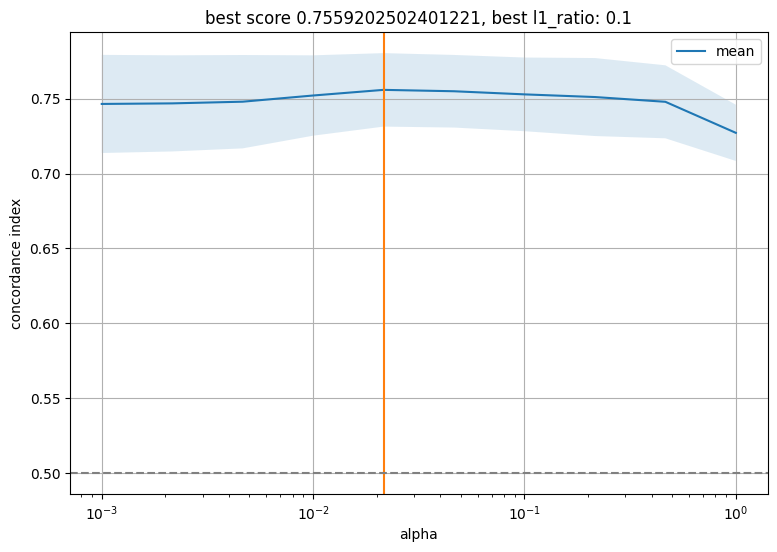

In [104]:
if cv_results.shape[0] > 1: # don't plot if there is only one alpha
    df = pd.DataFrame({
        'alpha': cv_results.param_coxnet__alphas.map(lambda x: x[0]), # 'unlist' each alpha value
        'mean': cv_results.mean_test_score,
        'std': cv_results.std_test_score,
    }).sort_values('alpha').reset_index(drop=True)
    print(df.head())
    print(df.shape)

    best_alpha = cls.best_params_["coxnet__alphas"][0]
    best_l1_ratio = cls.best_params_["coxnet__l1_ratio"]
    best_score = cls.best_score_

    ax = df.plot(x='alpha', y='mean', figsize=(9, 6))
    ax.fill_between(df['alpha'], df['mean'] - df['std'], df['mean'] + df['std'], alpha=0.15)
    ax.set_xscale("log")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.set_title(f'best score {best_score}, best l1_ratio: {best_l1_ratio}')
    ax.axvline(best_alpha, c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)


# K-M plots

In [105]:
km_df = pd.DataFrame(
    best_model.named_steps['preprocess'].transform(X),
    index=X.index,
    columns=best_model.named_steps['preprocess'].get_feature_names_out(),
)
km_df = km_df.loc[:, best_model.named_steps['select'].get_support()]
km_df = survival[[event_col, time_col]]\
    .merge(km_df[best_coefs_non_zero.index], how='inner', left_index=True, right_index=True)
#print(km_df.head())

## clinical features

In [106]:
clinical_coefs = best_coefs_non_zero[best_coefs_non_zero.index.str.startswith('clinical')]
clinical_coefs.iloc[:3]

clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -0.974735
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.480482
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.310740
dtype: float64

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

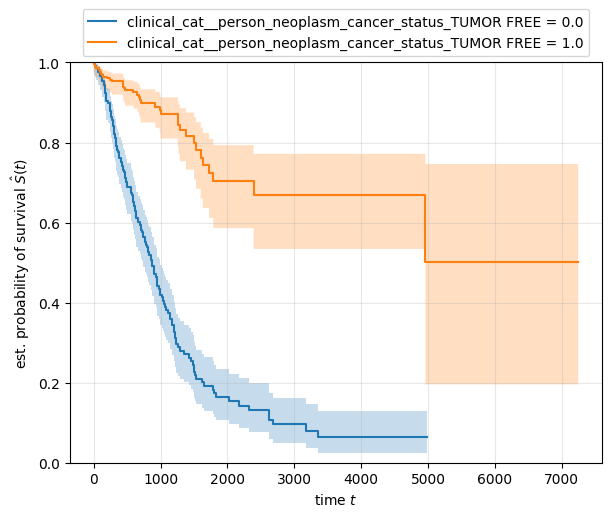

In [107]:
plot_kaplan_meier(km_df, clinical_coefs.index[0])


## eigengenes 

In [108]:
eigengene_coefs = best_coefs_non_zero[best_coefs_non_zero.index.str.startswith('eigengene')]
eigengene_coefs.iloc[:3]

eigengenes__eigengene_2   -0.26474
dtype: float64

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

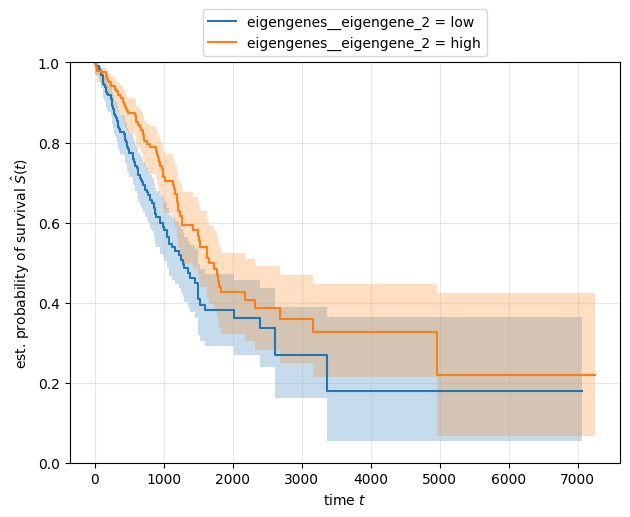

In [109]:
plot_kaplan_meier(km_df, eigengene_coefs.index[0])

## original genes

In [110]:
top_eigengene = eigengene_coefs.index[0].split('__')[-1]
top_eigengene

'eigengene_2'

In [111]:
eigengene_loadings = pd.read_parquet(data_dir_wgcna / 'loadings.parquet')
top_eigengene_loadings = eigengene_loadings.loc[:, top_eigengene]
top_eigengene_loadings = top_eigengene_loadings[top_eigengene_loadings.abs().sort_values(ascending=False).index]
top_eigengene_loadings.head()

SFTPC      0.073898
SCGB1A1    0.067587
PGC        0.067305
SCGB3A2    0.066881
SCGB3A1    0.066766
Name: eigengene_2, dtype: float64

In [112]:
# prepare df for making k-m plots
expression = pd.read_parquet(data_dir_eda / 'expression.parquet')
km_df = survival[[event_col, time_col]]\
    .merge(expression.loc[:,top_eigengene_loadings.index], how='inner', left_index=True, right_index=True)

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

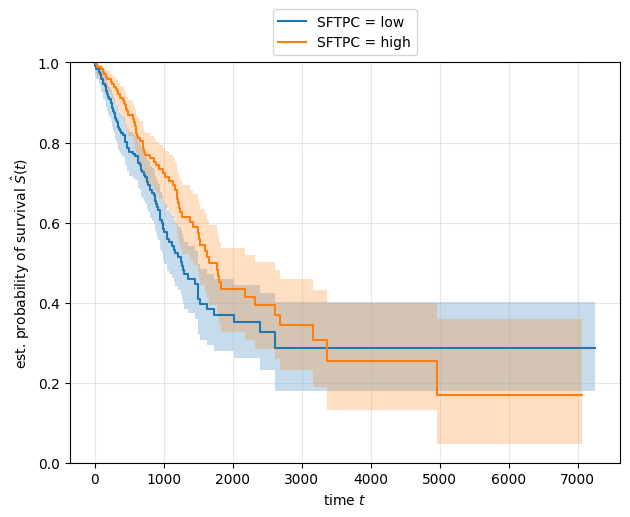

In [113]:
# gene with the highest loading 
plot_kaplan_meier(km_df, top_eigengene_loadings.idxmax())


<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

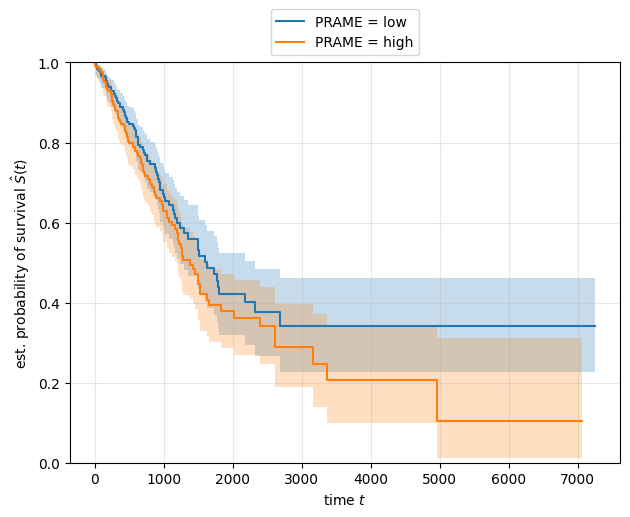

In [114]:
# gene with the lowest loading 
plot_kaplan_meier(km_df, top_eigengene_loadings.idxmin())
